In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve

print("SofaSofa.io rocks!")
# Based on
# http://sofasofa.io/tutorials/anomaly_detection/

SofaSofa.io rocks!


Using TensorFlow backend.


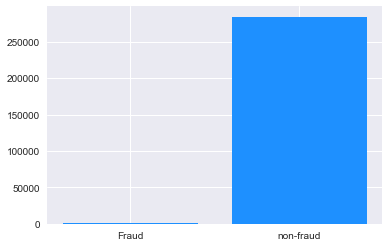

Train on 227452 samples, validate on 56863 samples
Epoch 1/50
227452/227452 [==============================] - 11s 49us/step - loss: 0.7884 - mean_absolute_error: 0.5278 - val_loss: 0.7399 - val_mean_absolute_error: 0.5039
Epoch 2/50
227452/227452 [==============================] - 11s 47us/step - loss: 0.7264 - mean_absolute_error: 0.5026 - val_loss: 0.7293 - val_mean_absolute_error: 0.5030
Epoch 3/50
227452/227452 [==============================] - 11s 48us/step - loss: 0.7197 - mean_absolute_error: 0.5006 - val_loss: 0.7222 - val_mean_absolute_error: 0.4994
Epoch 4/50
227452/227452 [==============================] - 11s 49us/step - loss: 0.7155 - mean_absolute_error: 0.4982 - val_loss: 0.7173 - val_mean_absolute_error: 0.4969
Epoch 5/50
227452/227452 [==============================] - 11s 47us/step - loss: 0.7124 - mean_absolute_error: 0.4965 - val_loss: 0.7168 - val_mean_absolute_error: 0.4970
Epoch 6/50
227452/227452 [==============================] - 12s 53us/step - loss: 0.7102 

227452/227452 [==============================] - 10s 43us/step - loss: 0.7007 - mean_absolute_error: 0.4922 - val_loss: 0.7044 - val_mean_absolute_error: 0.4929
Epoch 49/50
227452/227452 [==============================] - 10s 44us/step - loss: 0.7000 - mean_absolute_error: 0.4920 - val_loss: 0.7042 - val_mean_absolute_error: 0.4922
Epoch 50/50
227452/227452 [==============================] - 10s 44us/step - loss: 0.6995 - mean_absolute_error: 0.4920 - val_loss: 0.7040 - val_mean_absolute_error: 0.4923


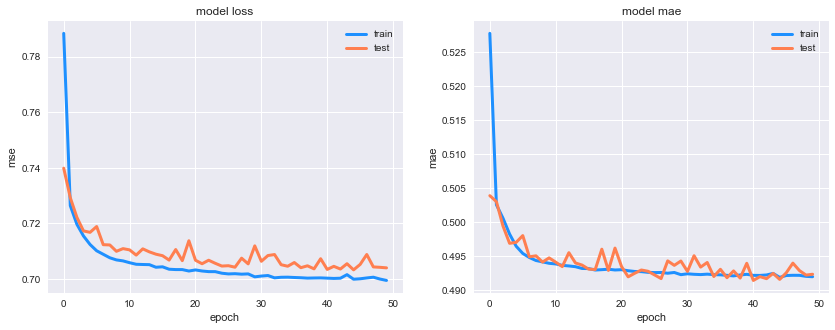

In [4]:
# 读取数据
d = pd.read_csv('creditcard.csv')

# 查看样本比例
num_nonfraud = np.sum(d['Class'] == 0)
num_fraud = np.sum(d['Class'] == 1)
plt.bar(['Fraud', 'non-fraud'], [num_fraud, num_nonfraud], color='dodgerblue')
plt.show()

# 删除时间列，对Amount进行标准化
data = d.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data[['Amount']])

# 提取负样本，并且按照8:2切成训练集和测试集
mask = (data['Class'] == 0)
X_train, X_test = train_test_split(data[mask], test_size=0.2, random_state=920)
X_train = X_train.drop(['Class'], axis=1).values
X_test = X_test.drop(['Class'], axis=1).values

# 提取所有正样本，作为测试集的一部分
X_fraud = data[~mask].drop(['Class'], axis=1).values

# 设置Autoencoder的参数
# 隐藏层节点数分别为16，8，8，16
# epoch为50，batch size为32
input_dim = X_train.shape[1]
encoding_dim = 16
num_epoch = 50
batch_size = 32

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])

# 模型保存为SofaSofa_model.h5，并开始训练模型
checkpointer = ModelCheckpoint(filepath="SofaSofa_model.h5",
                               verbose=0,
                               save_best_only=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=num_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1, 
                          callbacks=[checkpointer]).history

# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mean_absolute_error'], c='dodgerblue', lw=3)
plt.plot(history['val_mean_absolute_error'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mae'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [5]:
# 读取模型
autoencoder = load_model('SofaSofa_model.h5')

# 利用训练好的autoencoder重建测试集
pred_test = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)

# 计算还原误差MSE和MAE
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)
mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)

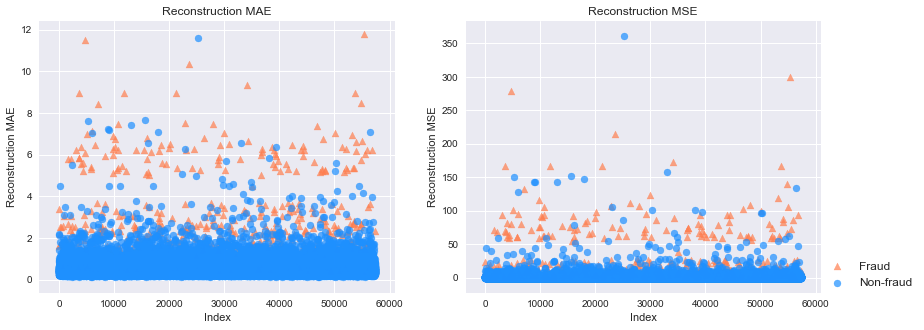

In [6]:
# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE'); plt.xlabel('Index')
plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE'); plt.xlabel('Index')
plt.show()

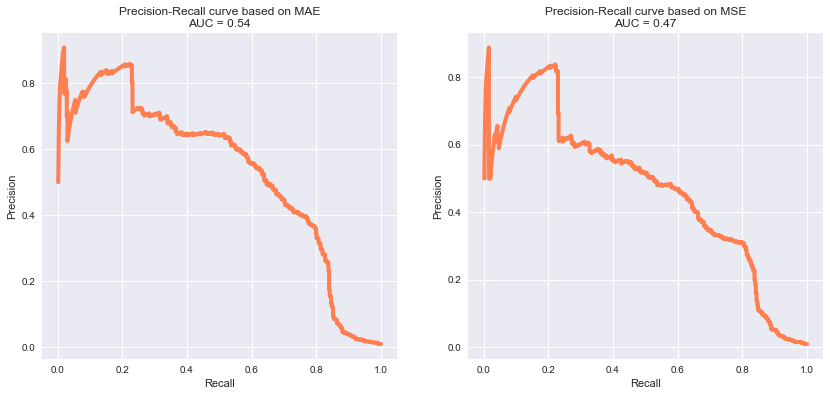

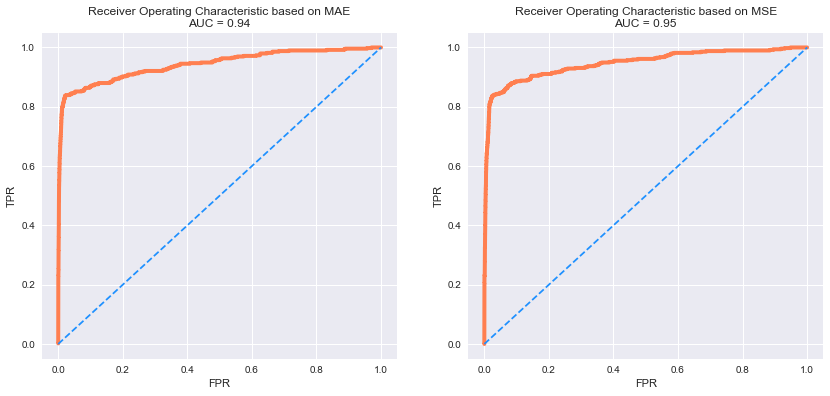

In [7]:
# 画出Precision-Recall曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    precision, recall, _ = precision_recall_curve(mse_df['Class'], mse_df[metric])
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

# 画出ROC曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Class'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.2f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

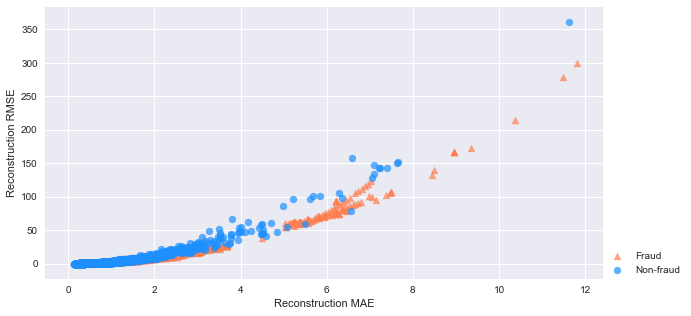

In [8]:
# 画出MSE、MAE散点图
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Non-fraud', 'Fraud']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()

In [9]:
mse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57355 entries, 0 to 57354
Data columns (total 3 columns):
Class    57355 non-null int64
MSE      57355 non-null float64
MAE      57355 non-null float64
dtypes: float64(2), int64(1)
memory usage: 1.3 MB


In [10]:
mse_df.head()

,Class,MSE,MAE
0,0,0.261778,0.359372
1,0,0.852294,0.658449
2,0,0.379520,0.450172
3,0,0.656489,0.613808
4,0,0.252442,0.388259


In [14]:
pred_test

array([[0.9886663 , 0.        , 0.27728283, ..., 0.        , 0.        ,
        0.        ],
       [2.3084688 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.86917543, 0.        , 0.09527576, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.4460505 , ..., 0.        , 0.        ,
        0.45473874],
       [0.        , 0.79198253, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.493534  , 0.50672364, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)